In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import Levenshtein
import time
import torchaudio
import librosa

from morse.models import CNNResidualBlock, TransformerResidualBlock, PoolingTransition, CNNTransformer, CTCHead
from morse.models import MySomething
from morse.models import SimpleCNN
from morse.my_datasets import ListDataset, load_tensors, filenames_to_torch
from morse.samplers import LongCTCSampler
from morse.augmentations import rotation_transform, make_volume_signal_transform, make_compose_signal_transform, make_noise_signal_transform
from morse.text_helpers import Vectorizer, encode_to_morse, decode_from_morse

from morse.my_datasets import generate_dataset, read_dataset_from_files
from morse.generators import volume_sinusoid_variation

In [2]:
labels_dir = '../'
audio_dir = '../morse_dataset'


dev_flag = True

fake_dataset_size = 100 if dev_flag else 30000 

full_train_df = pd.read_csv(Path(labels_dir, 'train.csv'))
test_df = pd.read_csv(Path(labels_dir, 'test.csv'))
full_train_df.head()

,id,message
0,1.opus,03ЩУЫЛПИГХ
1,2.opus,ЪЛТ0ДС6А3Г
2,3.opus,5ЭКЫБЗХЯН
3,4.opus,ЖЫЦОИ68КФ
4,5.opus,32Ю7МЫ ЗЛ


# synthetic

In [3]:
signal_tr = make_compose_signal_transform([
    make_volume_signal_transform(min_res=0.1),
    make_noise_signal_transform()
])

fake_train_set = generate_dataset(fake_dataset_size, signal_transform=signal_tr, runtime_transform=rotation_transform)
fake_val_set = generate_dataset(200, signal_transform=signal_tr)

100%|██████████| 200/200 [00:01<00:00, 169.24it/s]


In [4]:
# fake_mel, fake_message = generate_dataset(1, signal_transform=make_compose_signal_transform([make_volume_signal_transform(min_res=0.1),
#                                                                                            make_noise_signal_transform()]))[0]
# plt.imshow(fake_mel)
# plt.show()

# real

In [5]:
from sklearn.model_selection import train_test_split

train_index, val_index = train_test_split(np.arange(full_train_df.shape[0]), test_size=1/6, shuffle=True, 
                                           random_state=42)
real_val_set = read_dataset_from_files(audio_dir, 
                                       filenames = full_train_df.iloc[val_index]['id'], 
                                       labels=list(full_train_df.iloc[val_index]['message']))
print(len(real_val_set))

100%|██████████| 5000/5000 [01:25<00:00, 58.43it/s]


5000


# some helpers

In [6]:
index_to_letter = sorted(set(''.join(full_train_df['message'])))
pad_value = 0
print(index_to_letter)
letter_to_index = dict([(letter, i) for i, letter in enumerate(index_to_letter)])
dictionary_size = len(index_to_letter)
print(dictionary_size)
print(letter_to_index)

vectorizer = Vectorizer(letter_to_index, index_to_letter)
print(vectorizer.text_transform('ПРИВЕТ #'))


def batch_text_transform(texts):
    vecs, lengths = vectorizer.batch_text_transform(texts, pad_value=pad_value)
    return vecs + 1, lengths

[' ', '#', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я']
44
{' ': 0, '#': 1, '0': 2, '1': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11, 'А': 12, 'Б': 13, 'В': 14, 'Г': 15, 'Д': 16, 'Е': 17, 'Ж': 18, 'З': 19, 'И': 20, 'Й': 21, 'К': 22, 'Л': 23, 'М': 24, 'Н': 25, 'О': 26, 'П': 27, 'Р': 28, 'С': 29, 'Т': 30, 'У': 31, 'Ф': 32, 'Х': 33, 'Ц': 34, 'Ч': 35, 'Ш': 36, 'Щ': 37, 'Ъ': 38, 'Ы': 39, 'Ь': 40, 'Э': 41, 'Ю': 42, 'Я': 43}
tensor([27, 28, 20, 14, 17, 30,  0,  1])


In [7]:
device = 0 if torch.cuda.is_available() else 'cpu'
device

'cpu'

# model

In [8]:
n_epochs = 30
batch_size = 128

lr = 0.005
step_gamma = 0.359
dropout = 0.165

n_pools = 4
n_blocks_before_pool = 3
pooling_overlap = True

group = 'FreshStart'
run_name = 'testing'

config = {
    'n_epochs': n_epochs,
    'batch_size': batch_size,
    
    'lr': lr,
    'step_gamma': step_gamma,
    'dropout': dropout,

    'n_pools': n_pools,
    'n_blocks_before_pool': n_blocks_before_pool,
    'pooling_overlap': pooling_overlap,
}

In [9]:
model = SimpleCNN(d_input=64, d_model=64, d_inner=64, d_output=dictionary_size + 1, 
                  n_pools=n_pools, n_blocks_before_pool=n_blocks_before_pool, pooling_overlap=True, dropout=dropout)

In [10]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20], gamma=step_gamma)
ctc_loss = nn.CTCLoss()


fake_train_loader = torch.utils.data.DataLoader(fake_train_set, batch_size=batch_size, shuffle=True)
fake_val_loader = torch.utils.data.DataLoader(fake_val_set, batch_size=batch_size, shuffle=False)
real_val_loader = torch.utils.data.DataLoader(real_val_set, batch_size=batch_size, shuffle=False)

# with wandb.init(
#         **common_wandb_kvals,
#         group=group,
#         config=config,
#         name=run_name,
#         ) as run:
for epoch in range(n_epochs):
    model.train()
    fake_train_loss_buffer = []
    for features, labels in tqdm(fake_train_loader):
        features = features.to(device)
        targets, target_lengths = batch_text_transform(labels)
        targets, target_lengths = targets.to(device), target_lengths.to(torch.int32).to(device)
        outs = model(features).transpose(0, 2).transpose(1, 2)
        inputs = F.log_softmax(outs, dim=2)
        input_lengths = torch.full(size=(inputs.shape[1],), fill_value=inputs.shape[0], dtype=torch.int32).to(device)
        loss = ctc_loss(inputs, targets, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        fake_train_loss_buffer.append(loss.detach())
    scheduler.step()

    model.eval()
    fake_val_loss_buffer = []
    with torch.no_grad():
        for features, labels in tqdm(fake_val_loader):
            features = features.to(device)
            targets, target_lengths = batch_text_transform(labels)
            targets, target_lengths = targets.to(device), target_lengths.to(torch.int32).to(device)
            outs = model(features).transpose(0, 2).transpose(1, 2)
            inputs = F.log_softmax(outs, dim=2)
            input_lengths = torch.full(size=(inputs.shape[1],), fill_value=inputs.shape[0], dtype=torch.int32).to(device)
            loss = ctc_loss(inputs, targets, input_lengths, target_lengths)
            fake_val_loss_buffer.append(loss.detach())
    
    # model.eval()
    # real_val_loss_buffer = []
    # with torch.no_grad():
    #     for features, labels in tqdm(real_val_loader):
    #         features = features.to(device)
    #         targets, target_lengths = batch_text_transform(labels)
    #         targets, target_lengths = targets.to(device), target_lengths.to(torch.int32).to(device)
    #         outs = model(features).transpose(0, 2).transpose(1, 2)
    #         inputs = F.log_softmax(outs, dim=2)
    #         input_lengths = torch.full(size=(inputs.shape[1],), fill_value=inputs.shape[0], dtype=torch.int32).to(device)
    #         loss = ctc_loss(inputs, targets, input_lengths, target_lengths)
    #         real_val_loss_buffer.append(loss.detach())

    fake_train_loss_value = torch.mean(torch.stack(fake_train_loss_buffer)).item()
    fake_val_loss_value = torch.mean(torch.stack(fake_val_loss_buffer)).item()
    # real_val_loss_value = torch.mean(torch.stack(real_val_loss_buffer)).item()

    print('train: ', fake_train_loss_value)
    print('test:  ', fake_val_loss_value)
    # print('real val', real_val_loss_value)
        # wandb.log({
        #     'train_loss': train_loss_value,
        #     'test_loss': test_loss_value,
        #     'lr': scheduler.get_last_lr()[0],
        # })

100%|██████████| 2/2 [00:00<00:00,  4.79it/s]


train:  11.342581748962402
test:   10.900665283203125


100%|██████████| 2/2 [00:00<00:00,  5.63it/s]


train:  5.328204154968262
test:   11.602262496948242


100%|██████████| 2/2 [00:00<00:00,  5.70it/s]


train:  6.634068489074707
test:   10.876285552978516


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


train:  5.469740390777588
test:   11.612207412719727


100%|██████████| 2/2 [00:00<00:00,  5.61it/s]


train:  5.279010772705078
test:   11.660923957824707


100%|██████████| 2/2 [00:00<00:00,  5.13it/s]


train:  5.68002462387085
test:   10.863149642944336


100%|██████████| 2/2 [00:00<00:00,  6.10it/s]


train:  4.8298258781433105
test:   8.590900421142578


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


train:  4.650696277618408
test:   7.383441925048828


100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


train:  4.361240386962891
test:   6.918234825134277


100%|██████████| 2/2 [00:00<00:00,  4.25it/s]


train:  4.259210586547852
test:   6.281662940979004


100%|██████████| 2/2 [00:00<00:00,  5.75it/s]


train:  4.353915691375732
test:   5.886077880859375


100%|██████████| 2/2 [00:00<00:00,  5.41it/s]


train:  4.208796501159668
test:   5.502847671508789


100%|██████████| 2/2 [00:00<00:00,  5.56it/s]


train:  4.155800819396973
test:   5.122190475463867


100%|██████████| 2/2 [00:00<00:00,  5.31it/s]


train:  4.091362476348877
test:   4.833611011505127


100%|██████████| 2/2 [00:00<00:00,  5.52it/s]


train:  4.215427875518799
test:   4.687549591064453


100%|██████████| 2/2 [00:00<00:00,  5.36it/s]


train:  4.161805629730225
test:   4.657839775085449


100%|██████████| 2/2 [00:00<00:00,  5.59it/s]


train:  4.12523078918457
test:   4.710206985473633


100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


train:  4.120727062225342
test:   4.784309387207031


100%|██████████| 2/2 [00:00<00:00,  6.06it/s]


train:  4.066900730133057
test:   4.811034202575684


100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


train:  4.08171272277832
test:   4.7526092529296875


100%|██████████| 2/2 [00:00<00:00,  5.52it/s]


train:  4.062630653381348
test:   4.676347732543945


100%|██████████| 2/2 [00:00<00:00,  5.24it/s]


train:  4.034561634063721
test:   4.581231594085693


100%|██████████| 2/2 [00:00<00:00,  5.29it/s]


train:  4.0677080154418945
test:   4.489284515380859


100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


train:  4.048456192016602
test:   4.395155906677246


100%|██████████| 2/2 [00:00<00:00,  6.03it/s]


train:  4.039674282073975
test:   4.315439224243164


100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


train:  4.0332841873168945
test:   4.245661735534668


100%|██████████| 2/2 [00:00<00:00,  5.77it/s]


train:  4.014125347137451
test:   4.190958499908447


100%|██████████| 2/2 [00:00<00:00,  5.72it/s]


train:  4.0186896324157715
test:   4.15941047668457


100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


train:  4.0306782722473145
test:   4.140067100524902


100%|██████████| 2/2 [00:00<00:00,  5.92it/s]

train:  4.033287525177002
test:   4.133220672607422


In [11]:
star_filenames = test_df['id'][-17:][:6]
star_morse = [
    '-.. .- -- .. -. .- -- - / -.. --- - .. / .-. ... -.-- ... .- -- -.-. ..',
    '.. .-.. / -..- ... .-- . -.. - -.- ---. .-- -. - .. / .-.- -- -.. -- -.-- -- ..-- -. .-.- -- -.-. / ..-- - .. -.-- -- -..- - -.- - ---. -- -.-- -. / -.. - -.-- -- .-. --. --.. / . .--. .. --.',
    '.- -. .... / .-- ... --- . --. -..- / .-. / .-- -.- - -.. .- -- .. / -. -.- ---- -- -.. -. .. / --. . -.- -. ...- - .-',
    '.. .-.. / -.. .- ... -.. .--. / -..- ... --- . -- ..- -. - .. / .. --. .-- -.- ... --- . .--. / -..- -.- ... .... -.-- ... ..- ... / .... -. ..- / ..-- -. / .... -. .... -. ..- ... ..',
    '. - -..- - -.- .--. / -.. ... .-.- -. -.- -- -.-- --- -.-. / .. -- -.-',
    '-.- -. --- -..- -.- -- / ... --- . -. -.-- -- --- .--. / -..- ... ..-- -. .-- --',
]
star_dataset = read_dataset_from_files(audio_dir, filenames=star_filenames, labels=[decode_from_morse(m) for m in star_morse])

100%|██████████| 6/6 [00:00<00:00, 19.09it/s]


In [ ]:
model.eval()
star_loss_buffer = []
star_len_buffer = []
star_dist_buffer = []
with torch.no_grad():
    for features, labels in tqdm(star_dataset):
        features = features[None]
        labels = [labels]
        features = features.to(device)
        targets, target_lengths = batch_text_transform(labels)
        targets, target_lengths = targets.to(device), target_lengths.to(torch.int32).to(device)
        outs = model(features).transpose(0, 2).transpose(1, 2)

        probs = F.softmax(outs, dim=0).detach().to('cpu').squeeze().transpose(0, 1)
        seqs, likelihood = LongCTCSampler.sample(probs, beam_size=10)
        text = vectorizer.from_tensor(torch.tensor(seqs) - 1)
        dist = Levenshtein.distance(text, labels[0])
        star_dist_buffer.append(dist)

        inputs = F.log_softmax(outs, dim=2)
        input_lengths = torch.full(size=(inputs.shape[1],), fill_value=inputs.shape[0], dtype=torch.int32).to(device)
        loss = ctc_loss(inputs, targets, input_lengths, target_lengths)
        star_len_buffer.append(len(labels[0]))
        star_loss_buffer.append(loss.detach())
print(torch.mean(torch.stack(star_loss_buffer, dim=0)).item())
print(np.mean(star_len_buffer))
print(np.mean(star_dist_buffer))

  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([188, 1, 45])
torch.Size([45, 188])


 17%|█▋        | 1/6 [00:00<00:02,  1.90it/s]

torch.Size([188, 1, 45])
torch.Size([45, 188])


 33%|███▎      | 2/6 [00:00<00:01,  2.07it/s]

torch.Size([188, 1, 45])
torch.Size([45, 188])


 50%|█████     | 3/6 [00:01<00:01,  2.14it/s]

torch.Size([188, 1, 45])
torch.Size([45, 188])


 67%|██████▋   | 4/6 [00:01<00:00,  2.19it/s]

torch.Size([188, 1, 45])
torch.Size([45, 188])


 83%|████████▎ | 5/6 [00:02<00:00,  2.22it/s]

torch.Size([188, 1, 45])
torch.Size([45, 188])


100%|██████████| 6/6 [00:02<00:00,  2.18it/s]

4.372854232788086
34.166666666666664
73.66666666666667


In [ ]:
# # star_decoded = []
# for prob in tqdm(zip(star_probs)):
    
#     # star_decoded.append(text)
# print(len())

ИЛ ЬСВЕДТКЧВНТИ ЯМДМЫМЮНЯМЦ ЮТИЫМЬТКТЧМЫН ДТЫМРГЗ ЕПИГ
.. .-.. / -..- ... .-- . -.. - -.- ---. .-- -. - .. / .-.- -- -.. -- -.-- -- ..-- -. .-.- -- -.-. / ..-- - .. -.-- -- -..- - -.- - ---. -- -.-- -. / -.. - -.-- -- .-. --. --.. / . .--. .. --.


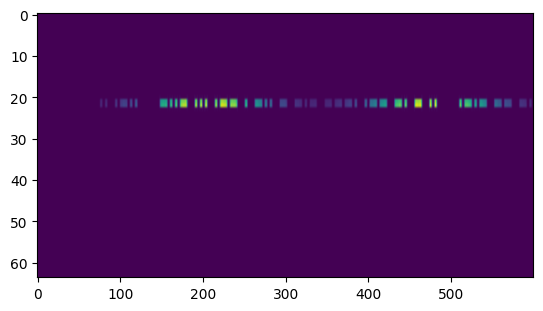

In [ ]:
star_mel, star_message = star_dataset[1]

print(star_message)
print(encode_to_morse(star_message))
plt.imshow(star_mel[:, :600], aspect=5)

In [ ]:
torch.save(model.state_dict(), f'{run_name}.pt')